In [1]:
import os

os.environ['MAC'] = 'True'
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
from common import get_data, handle_row_min_avg, handle_row_by_batch, TRAIN_COLOR, ANSWER_COLOR, IMAGE_PADDING, draw_rectangle, handle_row_random_batch, handle_row_random_batch_offset
from PIL import Image, ImageDraw, ImageFont
from draw import draw_rectangles, PREDICT_COLOR, MAX_COLOR

In [3]:
df = pd.read_csv('testset.csv', header=None)
data = np.asarray(df)
train_fields_count = data.shape[1] - 7
min_val = np.min(data, axis=0)
max_val = np.max(data, axis=0)
print(data.shape, min_val.shape, max_val.shape)

(28290, 42) (42,) (42,)


In [4]:
train_data = pd.read_csv('train_data.csv')
minmax_data = pd.read_csv('minmax.csv')
train_data = pd.read_csv('train_data.csv')
answers_data = pd.read_csv('train_answers.csv')
test_data = pd.read_csv('test_data.csv')
answers_id = np.asarray(answers_data.itemId)

In [5]:
def area(box):
    return (box[2] - box[0]) * (box[3] - box[1])


def intersection_over_union(boxes):
    assert(len(boxes) == 8)
    boxA = boxes[:4].values
    boxB = boxes[4:].values
    
    boxAArea = area(boxA)
    boxBArea = area(boxB)
    
    if (boxAArea == 0 or boxBArea == 0):
        return 0
        
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)

    
    denominator = float(boxAArea + boxBArea - interArea)
    if denominator == 0:
        return 1
    iou = interArea / denominator
    return iou

def get_middle(params):
    _min = params[:1].values
    _max = params[1:].values
    length = _max - _min
    return (_min + length / 2)[0]
    

In [6]:
def norm(data, min_val, max_val):
    return (data - min_val) / (max_val - min_val)

def xnorm(data, min_val, max_val):
    return data.reshape((data.shape[0], data.shape[1])) * (max_val - min_val) + min_val

def get_X(data, min_val, max_val):
    fields = data[:, 1:-6]
    fields = norm(fields, min_val[1:-6], max_val[1:-6] )
    return  fields.reshape(data.shape[0], train_fields_count, 1)

def get_Y(data, min_val, max_val):
    fields = data[:, -2:]
    fields = norm(fields, min_val[-2:], max_val[-2:] )
    return  fields.reshape(data.shape[0], 2)

x_test = get_X(data[:2], min_val, max_val)
y_test = get_Y(data[:2], min_val, max_val)

assert abs(np.sum(np.asanyarray(data[:2])[:, 1:-6] - xnorm(x_test, min_val[1:-6], max_val[1:-6]))) < 0.01
assert abs(np.sum(np.asanyarray(data[:2])[:, -2:] - xnorm(y_test, min_val[-2:], max_val[-2:]))) < 0.01

X = get_X(data, min_val, max_val)
Y = get_Y(data, min_val, max_val)
print(X.shape, Y.shape)

(28290, 35, 1) (28290, 2)


In [116]:
tf.keras.backend.clear_session()

In [33]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(
      filters=32, 
      kernel_size=7,
      strides=7, 
#       padding="causal",
      activation="relu",
      input_shape=(X.shape[1], 1)
  ),
#     tf.keras.layers.LSTM(64, return_sequences=True,input_shape=(X.shape[1], 1)),
#     tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(2, activation=tf.nn.sigmoid),
])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 5, 32)             256       
_________________________________________________________________
dense_16 (Dense)             (None, 5, 64)             2112      
_________________________________________________________________
dropout_12 (Dropout)         (None, 5, 64)             0         
_________________________________________________________________
dense_17 (Dense)             (None, 5, 64)             4160      
_________________________________________________________________
dropout_13 (Dropout)         (None, 5, 64)             0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                20544     
__________

In [34]:
# model = tf.keras.models.load_model(MODEL_NAME)

[37, -4]


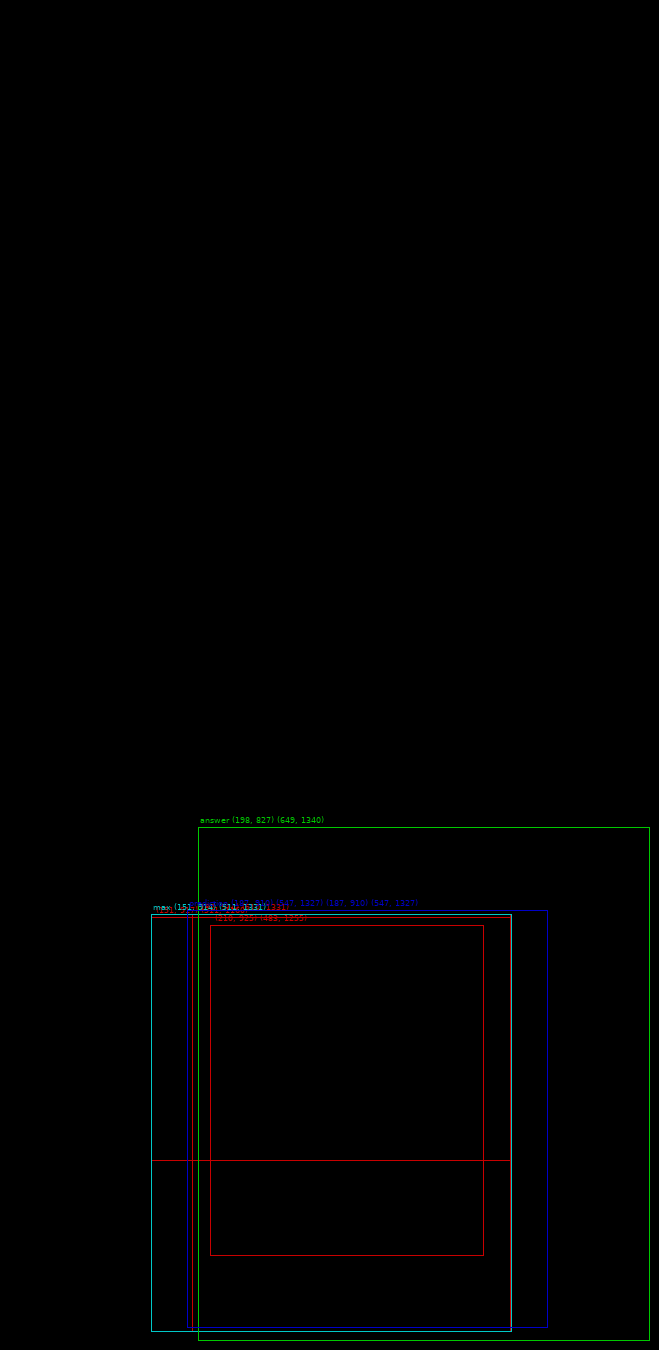

In [35]:
def predict(train, min_val, max_val):
    rows = np.array(
        handle_row_random_batch_offset(
            train, 
            np.array([[0,0,0,0,0,0,0]]), 
            samples_count=train_fields_count // 7, 
            premutations=1, 
            randomize=0
        )
    )
    x = get_X(rows, min_val, max_val)
    
    y = model.predict(x[:1,:])
    y = xnorm(y, min_val[-2:], max_val[-2:])
    y = y.reshape(2)
    y = np.round(y)
    
    return [int(x) for x in y.tolist()]

def get_bounds(train, answer):
    x = np.max(np.concatenate((
        np.asarray(train.Xmax), 
        np.asarray(train.Xmin),
        np.asarray(answer.Xmax_true), 
        np.asarray(answer.Xmin_true),
    )))
    
    y = np.max(np.concatenate((
        np.asarray(train.Ymax), 
        np.asarray(train.Ymin),
        np.asarray(answer.Ymax_true), 
        np.asarray(answer.Ymin_true),
    )))
    return np.max(x), np.max(y), np.min(x), np.min(y)

def draw_rectangles(train, answer):
    max_x, max_y, min_x, min_y =  get_bounds(train, answer)
    x1,y1,x2,y2 = handle_row_min_avg(train, answer)[0][1:5]
    ax1,ay1,ax2,ay2 = handle_row_min_avg(train, answer)[0][-4:]
    
    img = Image.new('RGB', (max_x + IMAGE_PADDING, max_y + IMAGE_PADDING))
    draw = ImageDraw.Draw(img)
    for row in train.iterrows():
        draw_rectangle(
            draw, 
            row[1]['Xmin'], 
            row[1]['Ymin'],
            row[1]['Xmax'], 
            row[1]['Ymax'], 
            '', 
            TRAIN_COLOR
        )
    draw_rectangle( draw, x1,y1,x2,y2, 'max', MAX_COLOR)
    draw_rectangle( draw, ax1,ay1,ax2,ay2, 'answer', ANSWER_COLOR)
        
    return img        

def draw_prediction(img, minmax, prediction):
    draw = ImageDraw.Draw(img)
    offset_x, offset_y =  prediction
    Xmin, Ymin, Xmax, Ymax = np.asarray(minmax)[0][-4:].tolist()
    
    Xmin = Xmin + offset_x
    Ymin = Ymin + offset_y
    Xmax = Xmax + offset_x
    Ymax = Ymax + offset_y
    
    draw_rectangle(
        draw, 
        Xmin, Ymin, Xmax, Ymax, 
        'prediction ({}, {}) ({}, {})'.format(Xmin, Ymin, Xmax, Ymax), PREDICT_COLOR 
    )
    return img

def predict_and_draw(image_id):
    train, answer = get_data(image_id, train_data, answers_data)
    prediction = predict(train, min_val, max_val)
    img = draw_rectangles(train, answer)
    
    minmax = minmax_data.loc[minmax_data.itemId == image_id][["itemId","Xmin","Ymin","Xmax","Ymax"]]
    return draw_prediction(img, minmax, prediction)

train, _ = get_data(5, train_data, answers_data)
print(predict(train, min_val, max_val))
predict_and_draw(5)

In [36]:
DESIRED_ACCURACY = 0.90
DESIRED_LOSS = 0.009
EPOCH = 50

def save_results(epoch, logs):
    for id in [5, 13, answers_id[33], answers_id[22]]:
        img = predict_and_draw(id)
        img.save("logs/epoch_{:08d}_{}.png".format(epoch,id))


    rows = []
    for image_id in answers_id:
        prediction = predict(image_id, train_data, min_val, max_val)
        rows.append(str(image_id)+','+",".join(str(int(x)) for x in prediction))

    with open('ttt', 'w') as f:
        f.write('itemId,Xmin,Ymin,Xmax,Ymax\n')
        f.write("\n".join([str(x) for x in rows]))        
        
    votes = pd.read_csv("ttt")
    data = votes.merge(answers_data, on=["itemId"])
    data["iou"] = data[['Xmin','Ymin', 'Xmax', 'Ymax', 'Xmin_true',\
          'Ymin_true', 'Xmax_true','Ymax_true']].apply(intersection_over_union, axis=1)
    iou = data["iou"].mean()
    model.save("models/epoch_{:08d}_{}".format(epoch, iou))
    with open('logs/epoch_{:08d}_iou'.format(epoch), 'w') as f:
        f.write("""
iou: {}

loss: {}
acc: {}
""".format(iou, logs.get('loss'), logs.get('acc')))

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch % EPOCH == 0:
            save_results(epoch, logs)
callbacks = myCallback()


In [37]:
model.compile(
    optimizer = tf.train.AdamOptimizer(),
    loss = tf.keras.losses.mean_squared_error,
    metrics=['accuracy'],
)

In [38]:
history = model.fit(x=X, y=Y, epochs=50, validation_split=0.05, batch_size=128, callbacks=[])

Train on 26875 samples, validate on 1415 samples
Epoch 1/50
26875/26875 [==============================] - 4s 158us/sample - loss: 0.0144 - acc: 0.7827 - val_loss: 0.0115 - val_acc: 0.8233
Epoch 2/50
26875/26875 [==============================] - 3s 113us/sample - loss: 0.0138 - acc: 0.7972 - val_loss: 0.0110 - val_acc: 0.8212
Epoch 3/50
26875/26875 [==============================] - 3s 123us/sample - loss: 0.0136 - acc: 0.7976 - val_loss: 0.0119 - val_acc: 0.8184
Epoch 4/50
26875/26875 [==============================] - 3s 121us/sample - loss: 0.0135 - acc: 0.7996 - val_loss: 0.0108 - val_acc: 0.8247
Epoch 5/50
26875/26875 [==============================] - 3s 120us/sample - loss: 0.0133 - acc: 0.8004 - val_loss: 0.0108 - val_acc: 0.8283
Epoch 6/50
26875/26875 [==============================] - 3s 121us/sample - loss: 0.0132 - acc: 0.8019 - val_loss: 0.0108 - val_acc: 0.8177
Epoch 7/50
26875/26875 [==============================] - 3s 120us/sample - loss: 0.0130 - acc: 0.8024 - val_lo

In [39]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation acc')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

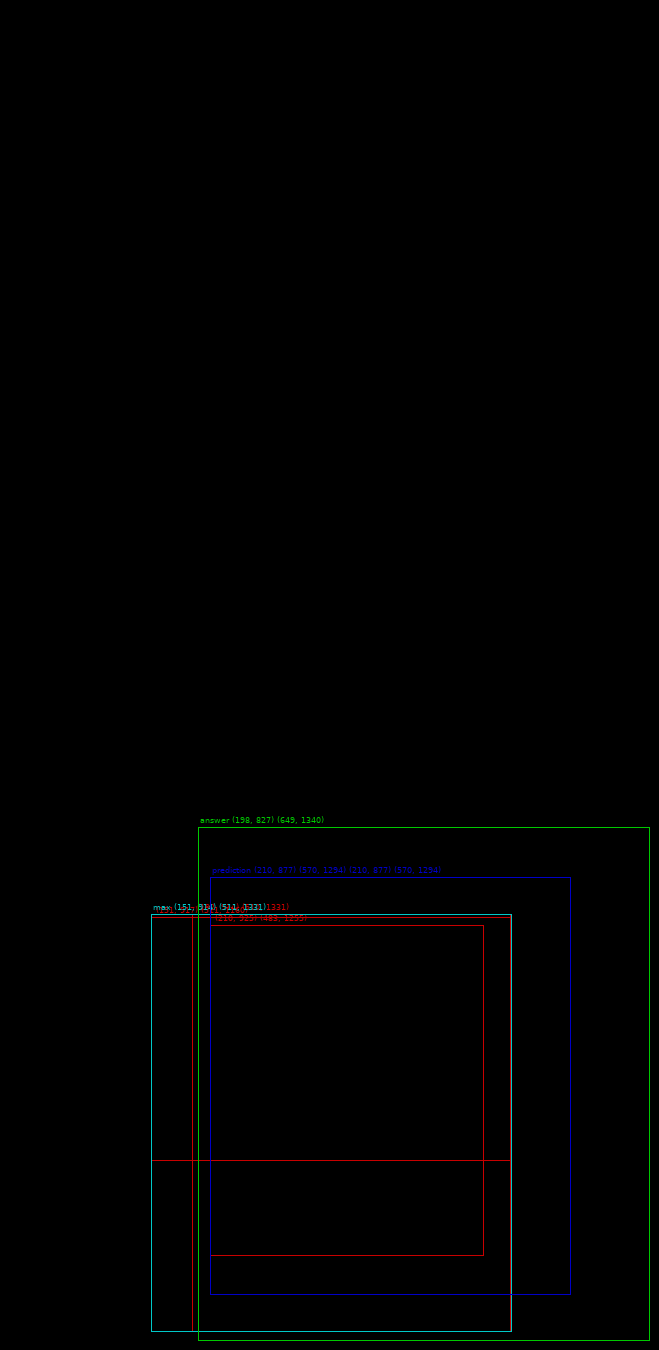

In [40]:
predict_and_draw(5)

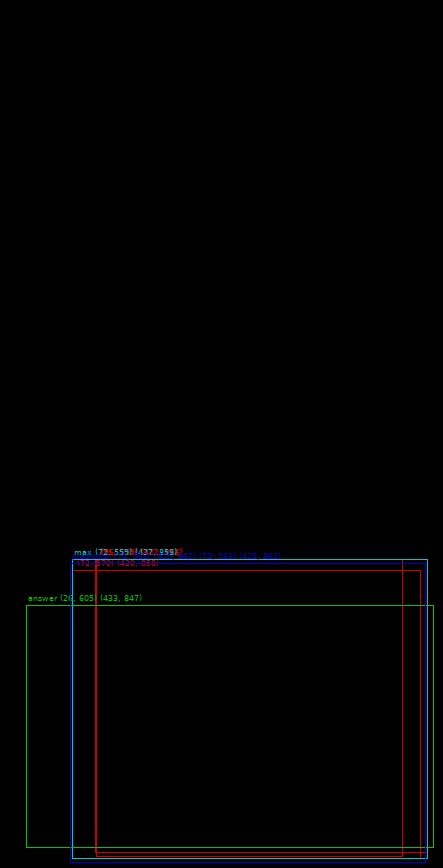

In [41]:
predict_and_draw(10)

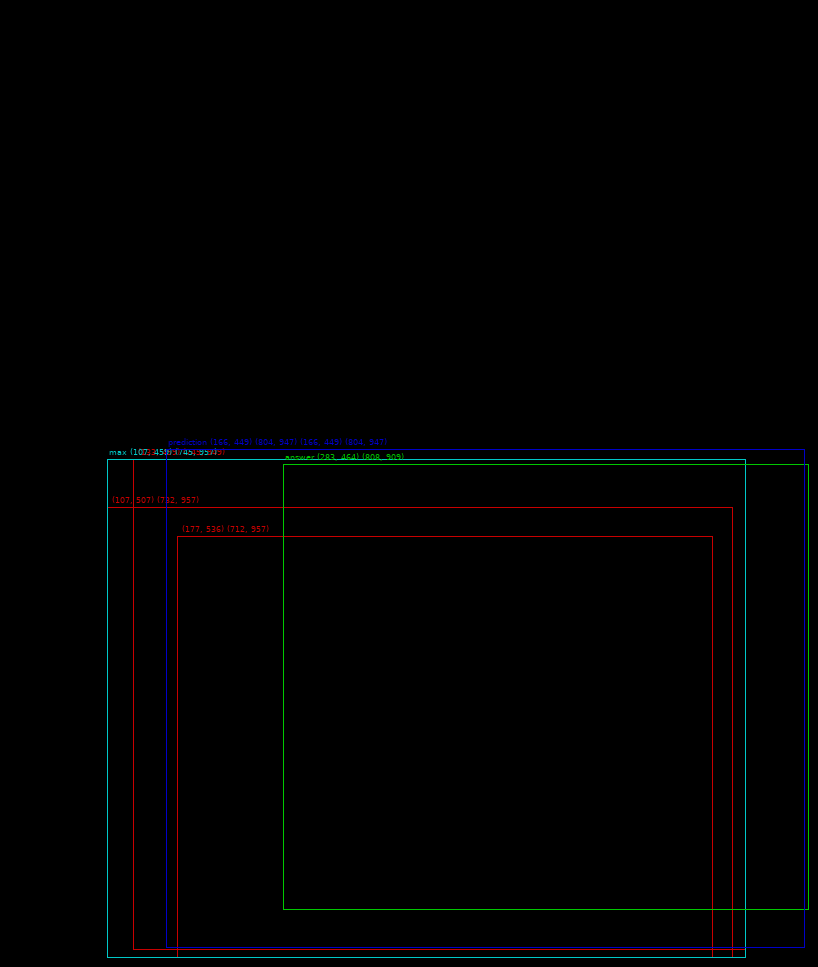

In [42]:
predict_and_draw(answers_id[33])

In [43]:
rows = []
for image_id in answers_id:
    train, answer = get_data(image_id, train_data, answers_data)
    prediction = predict(train, min_val, max_val)
    minmax = minmax_data.loc[minmax_data.itemId == image_id][["itemId","Xmin","Ymin","Xmax","Ymax"]]
    offset_x, offset_y =  prediction
    Xmin, Ymin, Xmax, Ymax = np.asarray(minmax)[0][-4:].tolist()
    
    Xmin = Xmin + offset_x
    Ymin = Ymin + offset_y
    Xmax = Xmax + offset_x
    Ymax = Ymax + offset_y
    
    rows.append(str(image_id)+','+",".join(str(int(x)) for x in [Xmin, Ymin, Xmax, Ymax]))

with open('ttt', 'w') as f:
    f.write('itemId,Xmin,Ymin,Xmax,Ymax\n')
    f.write("\n".join([str(x) for x in rows]))

In [44]:
test_answers = test_data.groupby("itemId")[['Xmin','Ymin', 'Xmax', 'Ymax']].mean().reset_index()[['itemId']].values
test_answers = test_answers.reshape(test_answers.shape[0]).tolist()

In [45]:
rows = []
for image_id in test_answers:
    train, answer = get_data(image_id, train_data, answers_data)
    prediction = predict(test_data, min_val, max_val)
    rows.append(str(image_id)+','+",".join(str(int(x)) for x in prediction))

with open('answer.csv', 'w') as f:
    f.write('itemId,Xmin,Ymin,Xmax,Ymax\n')
    f.write("\n".join([str(x) for x in rows]))

In [46]:
votes = pd.read_csv("ttt")
answers = pd.read_csv("train_answers.csv")
data = votes.merge(answers, on=["itemId"])
data["iou"] = data[['Xmin','Ymin', 'Xmax', 'Ymax', 'Xmin_true',\
      'Ymin_true', 'Xmax_true','Ymax_true']].apply(intersection_over_union, axis=1)
data["iou"].mean()

0.5925179755481063